In [0]:
#standard imports
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.sql.functions import log1p
import pyspark.sql.functions as f
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
import numpy as np
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.sql.functions import unix_timestamp, to_date, col
from pyspark.sql.functions import col, log1p, when, lit, row_number, hour, dayofweek, unix_timestamp, minute
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors # For converting Spark Vectors to dense arrays if needed
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

In [0]:
#select timeframe
def data_set(time):
    if time == 3:
        return "_3m"
    elif time == 6:
        return "_6m"
    elif time == 12:
        return "_1y"
    elif time == "all":
        return ""
    else:
        raise ValueError("time must be 3, 6, 12, or 'all'")

In [0]:
#set up path with rolling windows
dbfs_path = "dbfs:/student-groups/Group_02_01"
time =  "all" # CHANGE TIME 
time_length = data_set(time)  
splits_path = f"{dbfs_path}/fasw{time_length}"
final_path = f"{splits_path}/processed_rolling_windows" 

window_dirs = dbutils.fs.ls(final_path)
train_windows = [d.name for d in window_dirs if d.name.startswith("window_") and d.name.endswith("_train/")]
val_windows = [d.name for d in window_dirs if d.name.startswith("window_") and d.name.endswith("_val/")]
N_SPLITS = len(train_windows)

print(f"Loading folds from: {final_path}")
print(f"Detected {N_SPLITS} rolling windows")

Loading folds from: dbfs:/student-groups/Group_02_01/fasw/processed_rolling_windows
Detected 2 rolling windows


In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import lit, sin, cos, col
import math

# --- Define the VIF-safe features and their log counterparts ---
# Replace some features with _log versions
selected_features = [
    # Time
    "CRS_DEP_TIME",
    "CRS_ARR_TIME",
    "MONTH_cos",
    "MONTH_sin",
    "DOW_cos",
    "DOW_sin",
    "crs_time_to_next_flight_diff_mins_log",
    "actual_to_crs_time_to_next_flight_diff_mins_clean_log",

    # Location / route
    "ORIGIN_IDX",
    "DEST_IDX",
    "ORIGIN_LAT",
    "ORIGIN_LONG",
    "DEST_LAT",
    "DEST_LON",

    # Weather
    "HourlySeaLevelPressure",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "Ceiling_ft_agl",

    # Weather conditions
    "rain",
    "snow",
    "fog",

    # Flight / carrier
    "OP_UNIQUE_CARRIER_idx",

    # Holiday
    "is_us_holiday"

    #Graph Features
    "origin_pagerank",
    "dest_pagerank",
    "origin_out_degree",
    "dest_in_degree"
]

def add_cyclic_features(df):
    """Create cyclic sine/cosine features for MONTH and DAY_OF_WEEK."""
    df = df.withColumn("MONTH_sin", sin(2 * math.pi * col("MONTH")/12)) \
           .withColumn("MONTH_cos", cos(2 * math.pi * col("MONTH")/12)) \
           .withColumn("DOW_sin", sin(2 * math.pi * col("DAY_OF_WEEK")/7)) \
           .withColumn("DOW_cos", cos(2 * math.pi * col("DAY_OF_WEEK")/7)) \
           .drop("MONTH", "DAY_OF_WEEK") #make sure to drop

    return df



In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

def evaluate_window(preds, label_col="ARR_DEL15"):
    """
    Returns: recall, precision, f2, pr_auc
    """
    TP = preds.filter((col("prediction") == 1) & (col(label_col) == 1)).count()
    FP = preds.filter((col("prediction") == 1) & (col(label_col) == 0)).count()
    FN = preds.filter((col("prediction") == 0) & (col(label_col) == 1)).count()

    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    f2 = (5 * precision * recall) / ((4 * precision) + recall) if (precision + recall) > 0 else 0.0

    evaluator = BinaryClassificationEvaluator(
        labelCol=label_col,
        rawPredictionCol="probability",
        metricName="areaUnderPR"
    )
    pr_auc = evaluator.evaluate(preds)

    return recall, precision, f2, pr_auc

In [0]:
from pyspark.ml.classification import LogisticRegression

def build_logreg_pipeline(feature_cols, label_col="ARR_DEL15"):
    """
    Build a PySpark pipeline for logistic regression.
    Returns the pipeline and the feature column list.
    """
    feature_cols = selected_features #make sure features do NOT include label_col (prevent perf score)
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    lr = LogisticRegression(
        featuresCol="features",
        labelCol=label_col,
        probabilityCol="probability",
        predictionCol="prediction"
    )
    pipeline = Pipeline(stages=[assembler, lr])
    return pipeline, feature_cols

In [0]:
# PLOT PR-AUC (Precision-Recall) curve
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt

#manually plot PR-AUC curve
def plot_pr(preds, title="Precision–Recall Curve"):
    # get (score, label)
    rows = preds.select("probability", "ARR_DEL15").collect()
    data = [(float(r["probability"][1]), float(r["ARR_DEL15"])) for r in rows]

    # sort descending by score
    data.sort(key=lambda x: -x[0])

    tp = 0
    fp = 0
    positives = sum(y for _, y in data)

    recalls = []
    precisions = []

    for score, label in data:
        if label == 1:
            tp += 1
        else:
            fp += 1

        precision = tp / (tp + fp)
        recall    = tp / positives

        precisions.append(precision)
        recalls.append(recall)

    plt.figure(figsize=(7, 5))
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid()
    plt.show()

In [0]:
%skip
#BAYESIAN HYPERPARAMETER TUNING
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK

# Define search space
search_space = {
    'regParam': hp.loguniform('regParam', -5, 0),       # L2 regularization strength
    'elasticNetParam': hp.uniform('elasticNetParam', 0, 1),  # L1/L2 mix
    'maxIter': hp.quniform('maxIter', 50, 200, 10)
}

labelCol = "ARR_DEL15"

def hyperopt_objective(params):
    lr = LogisticRegression(
        featuresCol="features",
        labelCol=label_col,
        maxIter=int(params['maxIter']),
        regParam=params['regParam'],
        elasticNetParam=params['elasticNetParam']
    )
    model = lr.fit(train_df)
    preds = model.transform(val_df)
    
    # Evaluate using PR-AUC (or F2)
    evaluator = BinaryClassificationEvaluator(
        labelCol=label_col,
        rawPredictionCol="probability",
        metricName="areaUnderPR"
    )
    pr_auc = evaluator.evaluate(preds)
    
    return {'loss': -pr_auc, 'status': STATUS_OK}


In [0]:
%skip
def evaluate_logreg_on_folds_with_hparams(
    train_windows,
    val_windows,
    label_col="ARR_DEL15",
    vector_col="features",
    plot_pr_curve=True,
    feature_names=None,
    maxIter_vals=[100],
    regParam_vals=[0.01],
    elasticNetParam_vals=[0.0]
):
    """
    Evaluate Logistic Regression across rolling windows with hyperparameter tuning.
    Returns train/val metrics AND the best model per window.
    Prints metrics and top features for each window.
    """
    
    train_results = {"f2": [], "recall": [], "precision": [], "pr_auc": []}
    val_results   = {"f2": [], "recall": [], "precision": [], "pr_auc": []}
    best_models = []  # store best model per window
    
    for w_idx, (train_df, val_df) in enumerate(zip(train_windows, val_windows)):
        print(f"\n\n===================== WINDOW {w_idx+1} =====================")
        
        # Add cyclic features
        train_df = add_cyclic_features(train_df)
        val_df = add_cyclic_features(val_df)
        
        # Filter features
        if feature_names:
            existing_features = [f for f in feature_names if f in train_df.columns]
        else:
            existing_features = [f for f in train_df.columns if f != label_col]
        
        if not existing_features:
            raise ValueError(f"No valid features found in window {w_idx+1}")
        
        # Drop NA
        train_df = train_df.dropna(subset=existing_features + [label_col])
        val_df = val_df.dropna(subset=existing_features + [label_col])
        
        # Vector assembly
        assembler = VectorAssembler(inputCols=existing_features, outputCol=vector_col)
        train_df = assembler.transform(train_df)
        val_df = assembler.transform(val_df)
        
        best_model = None
        best_val_pr_auc = -1
        best_train_metrics = None
        best_val_metrics = None
        best_features = None
        
        for maxIter in maxIter_vals:
            for regParam in regParam_vals:
                for elastic in elasticNetParam_vals:
                    lr = LogisticRegression(
                        featuresCol=vector_col,
                        labelCol=label_col,
                        maxIter=maxIter,
                        regParam=regParam,
                        elasticNetParam=elastic
                    )
                    model = lr.fit(train_df)
                    
                    train_pred = model.transform(train_df)
                    val_pred = model.transform(val_df)
                    
                    rec_t, prec_t, f2_t, pr_t = evaluate_window(train_pred, label_col)
                    rec_v, prec_v, f2_v, pr_v = evaluate_window(val_pred, label_col)
                    
                    if pr_v > best_val_pr_auc:
                        best_val_pr_auc = pr_v
                        best_model = model
                        best_train_metrics = (f2_t, rec_t, prec_t, pr_t)
                        best_val_metrics = (f2_v, rec_v, prec_v, pr_v)
                        
                        # Get top feature (largest absolute coefficient)
                        import numpy as np
                        coef_array = np.array(model.coefficients)
                        top_idx = np.argmax(np.abs(coef_array))
                        best_features = existing_features[top_idx]
        
        # Store metrics
        f2_t, rec_t, prec_t, pr_t = best_train_metrics
        f2_v, rec_v, prec_v, pr_v = best_val_metrics
        
        train_results["f2"].append(f2_t)
        train_results["recall"].append(rec_t)
        train_results["precision"].append(prec_t)
        train_results["pr_auc"].append(pr_t)
        
        val_results["f2"].append(f2_v)
        val_results["recall"].append(rec_v)
        val_results["precision"].append(prec_v)
        val_results["pr_auc"].append(pr_v)
        
        best_models.append(best_model)
        
        # ===== PRINT OUTPUT FOR THIS WINDOW =====
        print(f"Train F2: {f2_t:.4f}, Recall: {rec_t:.4f}, Precision: {prec_t:.4f}, PR-AUC: {pr_t:.4f}")
        print(f"Val   F2: {f2_v:.4f}, Recall: {rec_v:.4f}, Precision: {prec_v:.4f}, PR-AUC: {pr_v:.4f}")
        print(f"Best feature for window {w_idx+1}: {best_features}")
    
    # Optionally, plot PR-AUC
    if plot_pr_curve:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(train_results["pr_auc"], label="Train PR-AUC")
        plt.plot(val_results["pr_auc"], label="Val PR-AUC")
        plt.title("PR-AUC Across Windows (Best Hyperparameters)")
        plt.xlabel("Window #")
        plt.ylabel("PR-AUC")
        plt.legend()
        plt.show()
    
    return train_results, val_results, best_models


In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
import matplotlib.pyplot as plt

def evaluate_windows_with_distributed_gridsearch(
    train_windows,
    val_windows,
    label_col="ARR_DEL15",
    feature_names=None,
    vector_col="features",
    maxIter_vals=[25, 50, 100], #maximum number of iterations
    regParam_vals=[0.01, 0.1, 0.5], #controls L1/L2 regularization strength to prevent overfitting
    elasticNetParam_vals=[0.0, 0.5, 1.0], #Controls how much L1 vs. L2 regularization is applied. (0.0 → pure L2 (ridge), 1.0 → pure L1 (lasso), 0.5 → elastic net (mix of L1 and L2))
    plot_pr_curve=True
):
    """
    Evaluate Logistic Regression across rolling windows using PySpark's distributed grid search
    (TrainValidationSplit) for each window. Avoids nested Python loops.
    
    Returns:
        train_results, val_results, best_models, best_features_list
    """
    train_results = {"f2": [], "recall": [], "precision": [], "pr_auc": []}
    val_results   = {"f2": [], "recall": [], "precision": [], "pr_auc": []}
    best_models = []
    best_features_list = []

    evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName="areaUnderPR")

    for w_idx, (train_df, val_df) in enumerate(zip(train_windows, val_windows)):
        print(f"\n\n===================== WINDOW {w_idx+1} =====================")
        train_df = add_cyclic_features(train_df)
        val_df = add_cyclic_features(val_df)

        # Filter features
        if feature_names:
            existing_features = [f for f in feature_names if f in train_df.columns]
        else:
            existing_features = [f for f in train_df.columns if f != label_col]

        train_df = train_df.dropna(subset=existing_features + [label_col])
        val_df = val_df.dropna(subset=existing_features + [label_col])

        # Vector assembly
        assembler = VectorAssembler(inputCols=existing_features, outputCol=vector_col)
        train_df = assembler.transform(train_df)
        val_df = assembler.transform(val_df)

        # Logistic Regression
        lr = LogisticRegression(featuresCol=vector_col, labelCol=label_col)

        # Parameter grid
        paramGrid = ParamGridBuilder() \
            .addGrid(lr.maxIter, maxIter_vals) \
            .addGrid(lr.regParam, regParam_vals) \
            .addGrid(lr.elasticNetParam, elasticNetParam_vals) \
            .build()

        # TrainValidationSplit (distributed)
        tvs = TrainValidationSplit(estimator=lr,
                                   estimatorParamMaps=paramGrid,
                                   evaluator=evaluator,
                                   trainRatio=0.8,
                                   parallelism=4)  # adjust for your cluster cores
        # Fit model on current window
        tvs_model = tvs.fit(train_df)
        best_model = tvs_model.bestModel

        # Predictions
        train_pred = best_model.transform(train_df)
        val_pred   = best_model.transform(val_df)

        # Evaluate
        rec_t, prec_t, f2_t, pr_t = evaluate_window(train_pred, label_col)
        rec_v, prec_v, f2_v, pr_v = evaluate_window(val_pred, label_col)

        train_results["f2"].append(f2_t)
        train_results["recall"].append(rec_t)
        train_results["precision"].append(prec_t)
        train_results["pr_auc"].append(pr_t)

        val_results["f2"].append(f2_v)
        val_results["recall"].append(rec_v)
        val_results["precision"].append(prec_v)
        val_results["pr_auc"].append(pr_v)

        best_models.append(best_model)

        # Best feature (largest absolute coefficient)
        coef_array = np.array(best_model.coefficients)
        top_idx = np.argmax(np.abs(coef_array))
        best_feature = existing_features[top_idx]
        best_features_list.append(best_feature)

        # Print metrics
        print(f"Train F2: {f2_t:.4f}, Recall: {rec_t:.4f}, Precision: {prec_t:.4f}, PR-AUC: {pr_t:.4f}")
        print(f"Val   F2: {f2_v:.4f}, Recall: {rec_v:.4f}, Precision: {prec_v:.4f}, PR-AUC: {pr_v:.4f}")
        print(f"Best feature for window {w_idx+1}: {best_feature}")
        print(f"Best hyperparameters: maxIter={best_model._java_obj.getMaxIter()}, "
              f"regParam={best_model._java_obj.getRegParam()}, elasticNetParam={best_model._java_obj.getElasticNetParam()}")

    # Optional PR-AUC plot
    if plot_pr_curve:
        plt.figure(figsize=(10, 5))
        plt.plot(train_results["pr_auc"], label="Train PR-AUC")
        plt.plot(val_results["pr_auc"], label="Val PR-AUC")
        plt.title("PR-AUC Across Windows")
        plt.xlabel("Window #")
        plt.ylabel("PR-AUC")
        plt.legend()
        plt.show()

    return train_results, val_results, best_models, best_features_list


In [0]:
# Read parquet files for all rolling windows
train_dfs = [spark.read.parquet(f"{final_path}/{w}") for w in train_windows]
val_dfs   = [spark.read.parquet(f"{final_path}/{v}") for v in val_windows]



===================== WINDOW 1 =====================
Train F2: 0.6630, Recall: 0.6826, Precision: 0.5944, PR-AUC: 0.6311
Val   F2: 0.5113, Recall: 0.6703, Precision: 0.2624, PR-AUC: 0.3022
Best feature for window 1: snow
Best hyperparameters: maxIter=50, regParam=0.1, elasticNetParam=0.0


===================== WINDOW 2 =====================
Train F2: 0.6590, Recall: 0.6749, Precision: 0.6021, PR-AUC: 0.6393
Val   F2: 0.5141, Recall: 0.6897, Precision: 0.2548, PR-AUC: 0.2872
Best feature for window 2: dest_pagerank
Best hyperparameters: maxIter=50, regParam=0.1, elasticNetParam=0.0


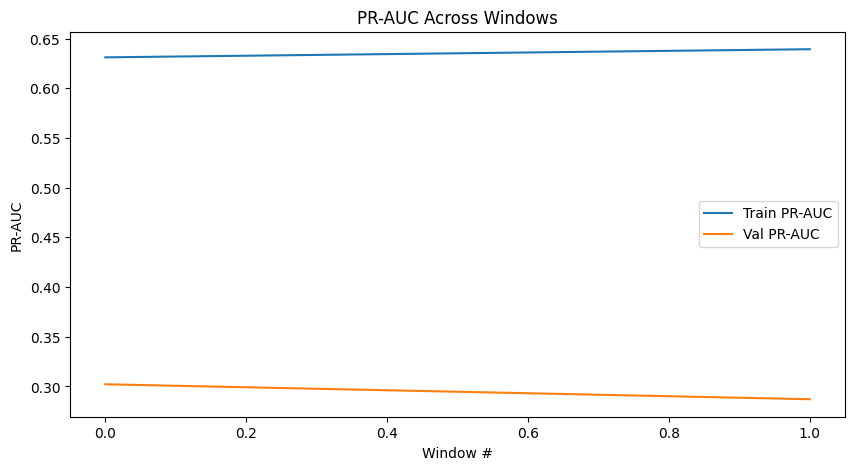

In [0]:


# Run Logistic Regression evaluation across rolling windows
train_metrics, val_metrics, best_models, best_features = evaluate_windows_with_distributed_gridsearch(
    train_windows=train_dfs,      # list of train window DataFrames
    val_windows=val_dfs,          # list of corresponding validation DataFrames
    label_col="ARR_DEL15",            # target column
    vector_col="features",            # assembled features column
    feature_names=selected_features,  # names for feature importance mapping
    plot_pr_curve=True,               # plot PR-AUC across windows
    maxIter_vals=[25, 50, 100], #maximum number of iterations
    regParam_vals=[0.01, 0.1, 0.5], #controls L1/L2 regularization strength to prevent overfitting
    elasticNetParam_vals=[0.0, 0.5, 1.0] #Controls how much L1 vs. L2 regularization is applied. (0.0 → pure L2 (ridge), 1.0 → pure L1 (lasso), 0.5 → elastic net (mix of L1 and L2))
)

## ML Flow Experiment

In [0]:
#set up path with rolling windows
dbfs_path = "dbfs:/student-groups/Group_02_01"
time = 12 #one year
time_length = data_set(time)  
splits_path = f"{dbfs_path}/fasw{time_length}"
final_path = f"{splits_path}/processed_rolling_windows" 

window_dirs = dbutils.fs.ls(final_path)
train_windows = [d.name for d in window_dirs if d.name.startswith("window_") and d.name.endswith("_train/")]
val_windows = [d.name for d in window_dirs if d.name.startswith("window_") and d.name.endswith("_val/")]
N_SPLITS = len(train_windows)

print(f"Loading folds from: {final_path}")
print(f"Detected {N_SPLITS} rolling windows")

time_length

Loading folds from: dbfs:/student-groups/Group_02_01/fasw_1y/processed_rolling_windows
Detected 6 rolling windows


'_1y'

In [0]:
dbutils.fs.mkdirs("dbfs:/student-groups/Group_02_01/experiments/lr") #create experiments folder

True

In [0]:
import mlflow
import mlflow.spark
from mlflow.exceptions import MlflowException

experiment_name = "/Workspace/Shared/Team_2_1/lr/logistic_regression_basic"
artifact_location = "dbfs:/student-groups/Group_02_01/experiments/lr"

if experiment_name is None:
    print("Experiment does NOT exist — creating it now...")

    # Make sure DBFS folder exists
    dbutils.fs.mkdirs(artifact_location)

    # Create new experiment
    experiment_id = mlflow.create_experiment(
        name=experiment_name,
        artifact_location=artifact_location
    )
    experiment = mlflow.get_experiment(experiment_id)
    print("Created experiment:", experiment_id)
else:
    print("Experiment already exists!")

# Final verification
print("Verified experiment:")
print(experiment_name)

# Set experiment for future runs
mlflow.set_experiment(experiment_name)


Experiment already exists!
Verified experiment:
/Workspace/Shared/Team_2_1/lr/logistic_regression_basic


<Experiment: artifact_location='dbfs:/student-groups/Group_02_01/experiments/lr', creation_time=1764807685236, experiment_id='3915201981341445', last_update_time=1764903801784, lifecycle_stage='active', name='/Shared/Team_2_1/lr/logistic_regression_basic', tags={'mlflow.experiment.sourceName': '/Shared/Team_2_1/lr/logistic_regression_basic',
 'mlflow.experimentKind': 'custom_model_development',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'Team_2_1',
 'mlflow.ownerId': '839106675862014'}>

In [0]:
%skip
import mlflow
import mlflow.spark
import numpy as np

# -----------------------------
# Experiment setup
# -----------------------------
experiment_name = "/Shared/Team_2_1/lr/logistic_regression_basic"
mlflow.set_experiment(experiment_name)

pip_requirements = ["pyspark==4.0.1", "pandas", "numpy"]

# -----------------------------
# Parent run
# -----------------------------
with mlflow.start_run(run_name="LR_rolling_gridsearch_parent") as parent_run:
    mlflow.log_param("num_windows", len(train_dfs))
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("search_method", "TrainValidationSplit")

    # -----------------------------
    # Nested runs per window
    # -----------------------------
    for w in range(len(best_models)):
        run_name = f"window_{w+1}"
        with mlflow.start_run(run_name=run_name, nested=True):

            # Log all metrics normally
            mlflow.log_metric("train_f2", train_results["f2"][w])
            mlflow.log_metric("val_f2", val_results["f2"][w])
            mlflow.log_metric("train_precision", train_results["precision"][w])
            mlflow.log_metric("val_precision", val_results["precision"][w])
            mlflow.log_metric("train_recall", train_results["recall"][w])
            mlflow.log_metric("val_recall", val_results["recall"][w])
            mlflow.log_metric("train_pr_auc", train_results["pr_auc"][w])
            mlflow.log_metric("val_pr_auc", val_results["pr_auc"][w])

            # Log best feature
            mlflow.log_param("best_feature", best_features[w])

            # Log model artifact for this window
            mlflow.spark.log_model(
                spark_model=best_models[w],
                artifact_path="best_model",
                pip_requirements=pip_requirements
            )

    # -----------------------------
    # log parent summary metrics
    # -----------------------------
    mlflow.log_metric("avg_train_f2", float(np.mean(train_results["f2"])))
    mlflow.log_metric("avg_val_f2", float(np.mean(val_results["f2"])))
    mlflow.log_metric("avg_train_precision", float(np.mean(train_results["precision"])))
    mlflow.log_metric("avg_val_precision", float(np.mean(val_results["precision"])))
    mlflow.log_metric("avg_train_recall", float(np.mean(train_results["recall"])))
    mlflow.log_metric("avg_val_recall", float(np.mean(val_results["recall"])))
    mlflow.log_metric("avg_train_pr_auc", float(np.mean(train_results["pr_auc"])))
    mlflow.log_metric("avg_val_pr_auc", float(np.mean(val_results["pr_auc"])))


In [0]:
# SHOWS LINE CHART FOR WINDOW COMPARISON IN MLFLOW
import mlflow
import mlflow.spark
import numpy as np

# -----------------------------
# Experiment setup
# -----------------------------
experiment_name = "/Shared/Team_2_1/lr/logistic_regression_basic"
mlflow.set_experiment(experiment_name)

pip_requirements = ["pyspark==4.0.1", "pandas", "numpy"]

# -----------------------------
# Run grid search FIRST to produce results
# -----------------------------
train_results, val_results, best_models, best_features = evaluate_windows_with_distributed_gridsearch(
    train_windows=train_dfs,
    val_windows=val_dfs,
    label_col="ARR_DEL15",
    feature_names=selected_features,
    maxIter_vals=[25, 50],
    regParam_vals=[0.01],
    elasticNetParam_vals=[0.0],
    plot_pr_curve=False
)

# -----------------------------
# Parent run
# -----------------------------
with mlflow.start_run(run_name="LR_rolling_gridsearch_parent") as parent_run:
    
    mlflow.log_param("num_windows", len(train_dfs))
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("search_method", "TrainValidationSplit")
    
    # Log one "representative" model artifact (optional: first window)
    mlflow.spark.log_model(
        spark_model=best_models[0],
        artifact_path="best_model",
        pip_requirements=pip_requirements
    )
    
    # -----------------------------
    # Log metrics for each window using 'step' as window number (starting at 1)
    # -----------------------------
    for w in range(len(best_models)):
        window_number = w + 1  # start windows at 1
        
        # Train metrics
        mlflow.log_metric("train_f2", train_results["f2"][w], step=window_number)
        mlflow.log_metric("train_precision", train_results["precision"][w], step=window_number)
        mlflow.log_metric("train_recall", train_results["recall"][w], step=window_number)
        mlflow.log_metric("train_pr_auc", train_results["pr_auc"][w], step=window_number)
        
        # Validation metrics
        mlflow.log_metric("val_f2", val_results["f2"][w], step=window_number)
        mlflow.log_metric("val_precision", val_results["precision"][w], step=window_number)
        mlflow.log_metric("val_recall", val_results["recall"][w], step=window_number)
        mlflow.log_metric("val_pr_auc", val_results["pr_auc"][w], step=window_number)
        
        # Best feature (optional)
        mlflow.log_param(f"best_feature_window_{window_number}", best_features[w])
    
    # -----------------------------
    # Optional: log average metrics
    # -----------------------------
    mlflow.log_metric("avg_train_f2", float(np.mean(train_results["f2"])))
    mlflow.log_metric("avg_val_f2", float(np.mean(val_results["f2"])))




===================== WINDOW 1 =====================
Train F2: 0.6618, Recall: 0.6808, Precision: 0.5955, PR-AUC: 0.6275
Val   F2: 0.5109, Recall: 0.6680, Precision: 0.2633, PR-AUC: 0.2992
Best feature for window 1: dest_pagerank
Best hyperparameters: maxIter=50, regParam=0.01, elasticNetParam=0.0


===================== WINDOW 2 =====================
Train F2: 0.6570, Recall: 0.6720, Precision: 0.6035, PR-AUC: 0.6359
Val   F2: 0.5143, Recall: 0.6896, Precision: 0.2550, PR-AUC: 0.2792
Best feature for window 2: dest_pagerank
Best hyperparameters: maxIter=25, regParam=0.01, elasticNetParam=0.0


In [0]:
%skip
# mlflow.set_tracking_uri("databricks")
# mlflow.set_experiment("xgboost_flight_delay_prediction")

if use_grid_search is not True:

    N_EST = 100
    RATE = 0.1
    DEPTH = 10

    experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_basic"

    experiment_id = mlflow.create_experiment(
        name=experiment_name,
        artifact_location="dbfs:/student-groups/Group_02_01/experiments/xgb"
    )
    mlflow.set_experiment(experiment_name)

    results = []
    target_col = "ARR_DEL15"

    xgb_classifier = SparkXGBClassifier(features_col="log_unscaled_features", label_col=target_col, random_state=42, n_estimators=N_EST, learning_rate=RATE, max_depth=DEPTH)

    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="recallByLabel", 
        metricLabel=1
    )
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="precisionByLabel",
        metricLabel=1
    )
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="f1"
    )
    f2_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="fMeasureByLabel",
        metricLabel=1,
        beta=2.0
    )
    pr_auc_evaluator = BinaryClassificationEvaluator(
        labelCol=target_col, 
        rawPredictionCol="rawPrediction",
        metricName="areaUnderPR" 
    )

    for i in range(N):
        xgb_train_path = f"{input_path}/window_{i+1}_train"
        xgb_val_path = f"{input_path}/window_{i+1}_val"
        train_df = spark.read.parquet(xgb_train_path)
        val_df = spark.read.parquet(xgb_val_path)
        
        with mlflow.start_run(run_name=f"xgb_window_{i}"):
            xgb_model = xgb_classifier.fit(train_df)
            val_preds = xgb_model.transform(val_df)

            recall = recall_evaluator.evaluate(val_preds) 
            precision = precision_evaluator.evaluate(val_preds)
            f1_score = f1_evaluator.evaluate(val_preds)
            pr_auc = pr_auc_evaluator.evaluate(val_preds)
            #f2_score = calculate_f2_score(precision, recall)
            f2_score = f2_evaluator.evaluate(val_preds)

            mlflow.log_param("n_estimators", N_EST)
            mlflow.log_param("learning_rate", RATE)
            mlflow.log_param("max_depth", DEPTH)
            mlflow.log_param("window", i)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("f1_score", f1_score)
            mlflow.log_metric("pr_auc", pr_auc)
            mlflow.log_metric("f2_score", f2_score)
            mlflow.spark.log_model(xgb_model, artifact_path="basic_model")

            # results.append({
            #     'window': i,
            #     'recall': recall,
            #     'precision': precision,
            #     'f1_score': f1_score,
            #     'pr_auc': pr_auc,
            #     'f2_score': f2_score
            # })
            # print(f"Window {i} complete. Recall: {results[-1]['recall']:.4f}")   

    # if results:
    #     results_df = pd.DataFrame(results)
    #     avg_metrics = results_df[['recall', 'precision', 'f1_score', 'pr_auc', 'f2_score']].mean()
    #     print("\n--- Averages Across All Windows ---")
    #     print(avg_metrics)

## BLIND TEST SET

In [0]:
#grab 5-year blind test dataset
blind_test_set_path = f"dbfs:/student-groups/Group_02_01/fasw/processed_train_test/test"
blind_train_set_path = f"dbfs:/student-groups/Group_02_01/fasw/processed_train_test/train"

print(f"Blind Test set path: {blind_test_set_path}")
print(f"Blind Train set path: {blind_train_set_path}")

#put into dataframe
blind_test_df = spark.read.parquet(blind_test_set_path)
blind_train_df = spark.read.parquet(blind_train_set_path)

Blind Test set path: dbfs:/student-groups/Group_02_01/fasw/processed_train_test/test
Blind Train set path: dbfs:/student-groups/Group_02_01/fasw/processed_train_test/train


In [0]:
#pick best model
best_idx = int(np.argmax(val_results["f2"]))
blind_test_model = best_models[best_idx]

print("Selected window:", best_idx+1)

Selected window: 2


In [0]:
#prep blind test so it goes through similar preprocessing as train

from pyspark.ml.feature import VectorAssembler

def prepare_blind_test(blind_df, feature_names, label_col="ARR_DEL15", vector_col="features"):
    # 1. Add cyclic features (same as training)
    blind_df = add_cyclic_features(blind_df)

    # 2. Subset to existing features (ignore missing ones)
    existing_features = [f for f in feature_names if f in blind_df.columns]

    # 3. Drop rows missing inputs
    blind_df = blind_df.dropna(subset=existing_features)

    # 4. Vector assembly
    assembler = VectorAssembler(inputCols=existing_features, outputCol=vector_col)
    blind_df = assembler.transform(blind_df)

    return blind_df, existing_features



In [0]:
# --- BLIND TEST EVALUATION WITH MLflow ---

import mlflow
import mlflow.spark
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# evaluators
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="ARR_DEL15", predictionCol="prediction", metricName="recallByLabel"
)

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="ARR_DEL15", predictionCol="prediction", metricName="precisionByLabel"
)

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="ARR_DEL15", predictionCol="prediction", metricName="f1"
)

pr_auc_evaluator = BinaryClassificationEvaluator(
    labelCol="ARR_DEL15", rawPredictionCol="rawPrediction", metricName="areaUnderPR"
)

def compute_f2(precision, recall):
    return (5 * precision * recall) / (4 * precision + recall) if (precision + recall) else 0


# -----------------------------
# 1. Prepare the blind test set
# -----------------------------
blind_prepared, used_features = prepare_blind_test(
    blind_test_df,
    selected_features,
    label_col="ARR_DEL15",
    vector_col="features"
)


# -----------------------------
# 2. Use the best model found during rolling windows
# -----------------------------
best_model = best_models[best_idx]   # IMPORTANT: do NOT refit on blind set


# -----------------------------
# 3. Run MLflow evaluation
# -----------------------------
with mlflow.start_run(run_name="blind_test"):

    mlflow.log_param("model_window_used", best_idx + 1)
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("num_features_used", len(used_features))

    # --- Evaluate on blind test ---
    blind_preds = best_model.transform(blind_prepared)

    recall = recall_evaluator.evaluate(blind_preds)
    precision = precision_evaluator.evaluate(blind_preds)
    pr_auc = pr_auc_evaluator.evaluate(blind_preds)
    f2_score = compute_f2(precision, recall)

    # --- Log metrics ---
    mlflow.log_metric("blind_recall", recall)
    mlflow.log_metric("blind_precision", precision)
    mlflow.log_metric("blind_pr_auc", pr_auc)
    mlflow.log_metric("blind_f2", f2_score)

    # --- Log model (optional) ---
    mlflow.spark.log_model(best_model, "best_window_model_for_blind_test")

# --- Print results in the notebook cell ---
print("\n=== Blind Test Results ===")
print(f"Recall:       {recall:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"PR AUC:       {pr_auc:.4f}")
print(f"F2 Score:     {f2_score:.4f}")
print("===========================\n")

print("Blind test evaluation complete!")


2025/12/05 03:38:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-19aea-f372f-f/tmpb5umxdbm, flavor: spark). Fall back to return ['pyspark==4.0.1']. Set logging level to DEBUG to see the full traceback. 



=== Blind Test Results ===
Recall:       0.5313
Precision:    0.8777
PR AUC:       0.2880
F2 Score:     0.5768

Blind test evaluation complete!


#### Checking Timeframe for each Window to prep for blind test

In [0]:
#CHECK TIME FRAME FOR EACH WINDOW 
# Requirement: “For the one-year OTPW dataset, please use the last quarter of the available one-year dataset as a blind test set that is never consulted during training”


# Existing setup
dbfs_path = "dbfs:/student-groups/Group_02_01"
time = 12
time_length = data_set(time)  
splits_path = f"{dbfs_path}/splits{time_length}"
folds_input_path = f"{splits_path}/processed"

window_dirs = dbutils.fs.ls(folds_input_path)

train_windows = sorted([d.name for d in window_dirs 
                        if d.name.startswith("window_") and d.name.endswith("_train/")])

val_windows = sorted([d.name for d in window_dirs 
                      if d.name.startswith("window_") and d.name.endswith("_val/")])

N_SPLITS = len(train_windows)

print(f"Loading folds from: {folds_input_path}")
print(f"Detected {N_SPLITS} rolling windows\n")

Loading folds from: dbfs:/student-groups/Group_02_01/splits_1y/processed
Detected 15 rolling windows



In [0]:

#USING FL_DATE to check date range
from pyspark.sql.functions import to_date, min as spark_min, max as spark_max

def show_window_timeframe(df, timestamp_col="FL_DATE"):
    result = df.agg(
        spark_min(timestamp_col).alias("start_date"),
        spark_max(timestamp_col).alias("end_date")
    ).collect()[0]
    print(f"Start: {result['start_date']} | End: {result['end_date']}")


for i in range(N_SPLITS):
    train_path = f"{folds_input_path}/{train_windows[i]}"
    val_path   = f"{folds_input_path}/{val_windows[i]}"

    # ⭐ Convert FL_DATE from string → date
    train_df = spark.read.parquet(train_path).withColumn("FL_DATE", to_date("FL_DATE"))
    val_df   = spark.read.parquet(val_path).withColumn("FL_DATE", to_date("FL_DATE"))

    print(f"=== Window {i} ===")
    print("Train timeframe:")
    show_window_timeframe(train_df)

    print("Val timeframe:")
    show_window_timeframe(val_df)

    print("----------------------------------------------------\n")

=== Window 0 ===
Train timeframe:
Start: 2019-05-16 | End: 2019-07-13
Val timeframe:
Start: 2019-07-13 | End: 2019-07-26
----------------------------------------------------

=== Window 1 ===
Train timeframe:
Start: 2019-05-31 | End: 2019-07-26
Val timeframe:
Start: 2019-07-26 | End: 2019-08-09
----------------------------------------------------

=== Window 2 ===
Train timeframe:
Start: 2019-06-14 | End: 2019-08-09
Val timeframe:
Start: 2019-08-09 | End: 2019-08-23
----------------------------------------------------

=== Window 3 ===
Train timeframe:
Start: 2019-06-28 | End: 2019-08-23
Val timeframe:
Start: 2019-08-23 | End: 2019-09-07
----------------------------------------------------

=== Window 4 ===
Train timeframe:
Start: 2019-07-13 | End: 2019-09-07
Val timeframe:
Start: 2019-09-07 | End: 2019-09-21
----------------------------------------------------

=== Window 5 ===
Train timeframe:
Start: 2019-07-26 | End: 2019-09-21
Val timeframe:
Start: 2019-09-21 | End: 2019-10-05
----

In [0]:
# USE MONTH, YEAR, DAY_OF_MONTH TO CHECK 
from pyspark.sql.functions import to_date, min as spark_min, max as spark_max, col, lpad, concat

def show_window_timeframe(df, timestamp_col="CHECK_DATE"):
    result = df.agg(
        spark_min(timestamp_col).alias("start_date"),
        spark_max(timestamp_col).alias("end_date")
    ).collect()[0]
    print(f"Start: {result['start_date']} | End: {result['end_date']}")
    

for i in range(N_SPLITS):
    train_path = f"{folds_input_path}/{train_windows[i]}"
    val_path   = f"{folds_input_path}/{val_windows[i]}"

    # Load parquet without touching FL_DATE
    train_df = spark.read.parquet(train_path)
    val_df   = spark.read.parquet(val_path)

    # ⭐ Create a "true" date from numeric fields
    train_df = train_df.withColumn(
        "CHECK_DATE",
        to_date(
            concat(
                col("YEAR"),
                lpad(col("MONTH"), 2, "0"),
                lpad(col("DAY_OF_MONTH"), 2, "0")
            ),
            "yyyyMMdd"
        )
    )

    val_df = val_df.withColumn(
        "CHECK_DATE",
        to_date(
            concat(
                col("YEAR"),
                lpad(col("MONTH"), 2, "0"),
                lpad(col("DAY_OF_MONTH"), 2, "0")
            ),
            "yyyyMMdd"
        )
    )

    print(f"=== Window {i} ===")
    print("Train timeframe:")
    show_window_timeframe(train_df, "CHECK_DATE")

    print("Val timeframe:")
    show_window_timeframe(val_df, "CHECK_DATE")

    print("----------------------------------------------------\n")


=== Window 0 ===
Train timeframe:
Start: 2019-05-16 | End: 2019-07-13
Val timeframe:
Start: 2019-07-13 | End: 2019-07-26
----------------------------------------------------

=== Window 1 ===
Train timeframe:
Start: 2019-05-31 | End: 2019-07-26
Val timeframe:
Start: 2019-07-26 | End: 2019-08-09
----------------------------------------------------

=== Window 2 ===
Train timeframe:
Start: 2019-06-14 | End: 2019-08-09
Val timeframe:
Start: 2019-08-09 | End: 2019-08-23
----------------------------------------------------

=== Window 3 ===
Train timeframe:
Start: 2019-06-28 | End: 2019-08-23
Val timeframe:
Start: 2019-08-23 | End: 2019-09-07
----------------------------------------------------

=== Window 4 ===
Train timeframe:
Start: 2019-07-13 | End: 2019-09-07
Val timeframe:
Start: 2019-09-07 | End: 2019-09-21
----------------------------------------------------

=== Window 5 ===
Train timeframe:
Start: 2019-07-26 | End: 2019-09-21
Val timeframe:
Start: 2019-09-21 | End: 2019-10-05
----

In [0]:
display(train_df)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE is_us_holiday OP_UNIQUE_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN ORIGIN_STATE_ABR DEST DEST_STATE_ABR CRS_DEP_TIME ARR_DEL15 CRS_ARR_TIME CRS_ELAPSED_TIME CARRIER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY DISTANCE DISTANCE_GROUP ORIGIN_LAT ORIGIN_LONG ORIGIN_ELEVATION_FT ORIGIN_SIZE STATION DEST_LAT DEST_LON DEST_ELEVATION_FT DEST_SIZE HourlyAltimeterSetting HourlyDewPointTemperature HourlyDryBulbTemperature HourlyPrecipitation HourlyPressureChange HourlyPressureTendency HourlyRelativeHumidity HourlySeaLevelPressure HourlyStationPressure HourlyVisibility HourlyWetBulbTemperature HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed has_few has_sct has_bkn has_ovc overall_oktas overall_cloud_frac_0_1 LowestBase_ft_agl HighestBase_ft_agl MeanBase_ft_agl BaseRange_ft_agl Ceiling_ft_agl sky_missing intensity_light intensity_heavy vicinity desc_shallow desc_patches desc_partial desc_low_drifting desc_blowing desc_thunderstorm desc_freezing desc_showers rain drizzle snow snow_grains ice_pellets small_hail_graupel hail ice_crystals unknown_precip mist fog smoke haze dust sand squalls freezing_rain freezing_drizzle blowing_snow drifting_snow thunderstorm_rain snow_showers rain_showers record_id OP_UNIQUE_CARRIER_idx ORIGIN_idx ORIGIN_STATE_ABR_idx DEST_idx DEST_STATE_ABR_idx ORIGIN_SIZE_idx DEST_SIZE_idx OP_UNIQUE_CARRIER_ohe ORIGIN_ohe ORIGIN_STATE_ABR_ohe DEST_ohe DEST_STATE_ABR_ohe ORIGIN_SIZE_ohe DEST_SIZE_ohe CRS_ELAPSED_TIME_log DISTANCE_log ORIGIN_ELEVATION_FT_log DEST_ELEVATION_FT_log HourlyPrecipitation_log HourlyWindGustSpeed_log LowestBase_ft_agl_log BaseRange_ft_agl_log Ceiling_ft_agl_log features_num features_num_scaled CHECK_DATE 2019 2 5 30 4 2019-05-30 1 AA N852NN 871 MIA FL LGA NY 1920 1 2218 178.0 0 49 0 0.0 1096.0 5 25.79319953918457 -80.29060363769531 8 large_airport 72202012839 40 -73 21 large_airport 30.00652605553947 73.0 82.0 0.0 -0.03 1 74.0 30.0 29.97 9.94 76.0 90 25.488607976955993 9.0 0 0 0 0 4.252980599633772 0.5316225749542215 1500.0 1500.0 1500.0 0.0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2863104 2.0 26.0 2.0 8.0 5.0 0.0 0.0 Map(vectorType -> sparse, length -> 17, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 348, indices -> List(26), values -> List(1.0)) Map(vectorType -> sparse, length -> 49, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 349, indices -> List(8), values -> List(1.0)) Map(vectorType -> sparse, length -> 49, indices -> List(5), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) 5.187385805840755 7.00033446027523 2.1972245773362196 3.091042453358316 0.0 3.2767147529019476 7.313886831633462 0.0 0.0 Map(vectorType -> dense, length -> 17, values -> List(1920.0, 2218.0, 25.79319953918457, -80.29060363769531, 40.0, -73.0, 30.00652605553947, 73.0, 82.0, 74.0, 30.0, 29.97, 9.94, 76.0, 90.0, 4.252980599633772, 0.5316225749542215)) Map(vectorType -> dense, length -> 17, values -> List(1.1860522211617306, 1.4011143642473838, -1.9500312771280137, 0.7837164458101065, NaN, NaN, 0.42861087763419353, 1.415238681935223, 0.8284264724509518, 0.6595546914477681, 0.5092623957323916, 0.7111970714052464, 0.22334690751833733, 1.4503370453659064, -0.7128457783621026, -0.11698320405288602, -0.11698320405288602)) 2019-05-30 2019 2 5 30 4 2019-05-30 1 NK N641NK 324 MCO FL ACY NJ 1920 1 2139 139.0 232 0 0 0.0 852.0 4 28.429399490356445 -81.30899810791016 96 large_airport 72205012815 39 -74 75 medium_airport 29.98 71.0 79.0 0.0 -0.05 1 77.0 29.98 29.87 10.0 74.0 150 25.488607976955993 7.0 1 0 0 0 2.0 0.25 6000.0 6000.0 6000.0 0.0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2863106 12.0 16.0 2.0 185.0 18.0 0.0 1.0 Map(vectorType -> sparse, length -> 17, indices -> List(12), values -> List(1.0)) Map(vectorTyp

## Appendix

In [0]:
%skip
from pyspark.ml.feature import VectorAssembler

# ---------------------------
# 3. Add cyclic features (if your model expects them)
# ---------------------------
test_df = add_cyclic_features(test_df)

# ---------------------------
# 2. Drop NA rows for these features + target
# ---------------------------
test_df = test_df.dropna(subset=existing_features + ['ARR_DEL15'])

# ---------------------------
# 1. Filter only features used in training
# ---------------------------
existing_features = [f for f in selected_features if f in test_df.columns]

# ---------------------------
# 4. Vector assembly
# ---------------------------
# Drop existing 'features' column if it exists
if 'features' in test_df.columns:
    test_df = test_df.drop('features')

assembler = VectorAssembler(
    inputCols=existing_features,
    outputCol="features"  # must match what the model expects
)
test_df = assembler.transform(test_df)

# ---------------------------
# 5. Predict using saved best_model
# ---------------------------
test_pred = best_model.transform(test_df)

# ---------------------------
# 6. Evaluate metrics using your function
# ---------------------------
rec, prec, f2, pr_auc = evaluate_window(test_pred, 'ARR_DEL15')

print(f"Test set metrics -- F2: {f2:.4f}, Recall: {rec:.4f}, Precision: {prec:.4f}, PR-AUC: {pr_auc:.4f}")


In [0]:
%skip
#calculate VIF for selected features
def calculate_vif(df, features):
    """Compute VIF for a given DataFrame and list of features."""
    vif_data = []
    for col_name in features:
        other_features = [f for f in features if f != col_name]
        assembler = VectorAssembler(inputCols=other_features, outputCol="features_vec")
        temp_df = assembler.transform(df).select(col_name, "features_vec").withColumnRenamed(col_name, "label")
        lr = LinearRegression(featuresCol="features_vec", labelCol="label")
        lr_model = lr.fit(temp_df)
        r2 = lr_model.summary.r2
        vif = 1.0 / (1.0 - r2) if r2 < 1 else float('inf')
        vif_data.append((col_name, vif))
    return vif_data

# --- Iterate through rolling windows ---
vif_results_all = []

for window in train_windows:
    window_path = f"{folds_input_path}/{window}"
    df_window = spark.read.parquet(window_path)
    
    # Ensure consistent columns: add missing columns as zeros
    for feat in vif_features_base:
        if feat not in df_window.columns:
            df_window = df_window.withColumn(feat, lit(0.0))
    
    # Keep only VIF-safe features
    df_window = df_window.select(*vif_features_base)
    
    # Add cyclic features
    df_window = add_cyclic_features(df_window)
    
    # Include cyclic features in VIF computation
    vif_features = [f for f in df_window.columns]
    
    # Compute VIF for this window
    vif_results = calculate_vif(df_window, vif_features)
    
    # Add window identifier
    vif_results = [(window, f, v) for f, v in vif_results]
    vif_results_all.extend(vif_results)

# Convert to DataFrame for analysis
vif_df = spark.createDataFrame(vif_results_all, ["window", "feature", "VIF"])
display(vif_df)


In [0]:
%skip 
from pyspark.sql.functions import col, to_date, dayofweek, month, sin, cos, lit
import math

# 1️⃣ Convert FL_DATE to date type and extract time features
df = df.withColumn("FL_DATE_dt", to_date("FL_DATE", "yyyy-MM-dd")) \
       .withColumn("MONTH", month("FL_DATE_dt")) \
       .withColumn("DAY_OF_WEEK", dayofweek("FL_DATE_dt"))

# Optional: cyclical encoding for logistic regression
df = df.withColumn("MONTH_sin", sin(2 * math.pi * col("MONTH")/12)) \
       .withColumn("MONTH_cos", cos(2 * math.pi * col("MONTH")/12)) \
       .withColumn("DOW_sin", sin(2 * math.pi * col("DAY_OF_WEEK")/7)) \
       .withColumn("DOW_cos", cos(2 * math.pi * col("DAY_OF_WEEK")/7))

# 2️⃣ Define columns to drop (high VIF, redundant, or post-event)
drop_cols = [
    # Post-event / target
    "ARR_DEL15", "CARRIER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY",
    # Redundant time
    "YEAR", "QUARTER", "DAY_OF_MONTH",
    # Cloud / ceiling highly correlated
    "overall_oktas", "overall_cloud_frac_0_1", "HighestBase_ft_agl", "BaseRange_ft_agl",
    # Sparse precipitation / extreme weather
    "freezing_rain", "freezing_drizzle", "blowing_snow", "snow_showers", "rain_showers",
    "snow_grains", "small_hail_graupel", "hail", "ice_crystals", "sand", "drifting_snow",
    # Desc dummies - drop last category per group manually
    "desc_partial", "desc_low_drifting", "desc_blowing"
    # Log features if originals are kept
    "CRS_ELAPSED_TIME_log", "DISTANCE_log", "LowestBase_ft_agl_log", "HourlyPrecipitation_log"
]

df_clean = df.drop(*drop_cols)

# 3️⃣ Optional: Keep only n-1 categories for OHE groups
# Example for 'desc_' features (assuming these exist)
desc_columns = [c for c in df_clean.columns if c.startswith("desc_")]
if desc_columns:
    desc_columns.sort()  # Ensure consistent order
    df_clean = df_clean.drop(desc_columns[-1])  # Drop last category per group

# 4️⃣ Keep only relevant numeric / categorical features
keep_cols = [
    "MONTH_sin", "MONTH_cos", "DOW_sin", "DOW_cos",
    "is_us_holiday",
    "OP_CARRIER_FL_NUM",
    "ORIGIN_idx", "DEST_idx",
    "ORIGIN_STATE_ABR_idx", "DEST_STATE_ABR_idx",
    "ORIGIN_SIZE_idx", "DEST_SIZE_idx",
    "CRS_DEP_TIME", "CRS_ARR_TIME",
    "LowestBase_ft_agl", "Ceiling_ft_agl",
    "HourlyPrecipitation", "HourlyWindGustSpeed",
    "HourlyAltimeterSetting", "HourlySeaLevelPressure", "HourlyStationPressure",
    "HourlyVisibility", "HourlyRelativeHumidity",
    "rain", "drizzle", "snow", "mist", "fog", "smoke", "haze"
]

# Ensure only columns that exist in df_clean
keep_cols = [c for c in keep_cols if c in df_clean.columns]
df_final = df_clean.select(*keep_cols)

# df_final is ready for logistic regression
df_final.printSchema()
df_final.show(5)
